In [1]:
%pip install matplotlib numpy datasets transformers

  Using cached matplotlib-3.10.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp310-cp310-macosx_10_9_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyarrow-19.0.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp310-c

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the MATH dataset
dataset = load_dataset("DigitalLearningGmbH/MATH-lighteval", "default")
print(f"Dataset loaded with {len(dataset)} training examples")

Dataset loaded with 2 training examples


{'problem': 'Let \\[f(x) = \\left\\{\n\\begin{array}{cl} ax+3, &\\text{ if }x>2, \\\\\nx-5 &\\text{ if } -2 \\le x \\le 2, \\\\\n2x-b &\\text{ if } x <-2.\n\\end{array}\n\\right.\\]Find $a+b$ if the piecewise function is continuous (which means that its graph can be drawn without lifting your pencil from the paper).',
 'level': 'Level 5',
 'solution': 'For the piecewise function to be continuous, the cases must "meet" at $2$ and $-2$. For example, $ax+3$ and $x-5$ must be equal when $x=2$. This implies $a(2)+3=2-5$, which we solve to get $2a=-6 \\Rightarrow a=-3$. Similarly, $x-5$ and $2x-b$ must be equal when $x=-2$. Substituting, we get $-2-5=2(-2)-b$, which implies $b=3$. So $a+b=-3+3=\\boxed{0}$.',
 'type': 'Algebra'}

Tokenizer loaded: Qwen/Qwen2.5-Math-7B
Calculating token lengths for training set...
Processed 0/7500 examples
Processed 1000/7500 examples
Processed 2000/7500 examples
Processed 3000/7500 examples
Processed 4000/7500 examples
Processed 5000/7500 examples
Processed 6000/7500 examples
Processed 7000/7500 examples
Token length statistics:
  Average: 75.38
  Median: 49.0
  Min: 7
  Max: 1654
  90th percentile: 149.0
  95th percentile: 230.0
  99th percentile: 464.0500000000011


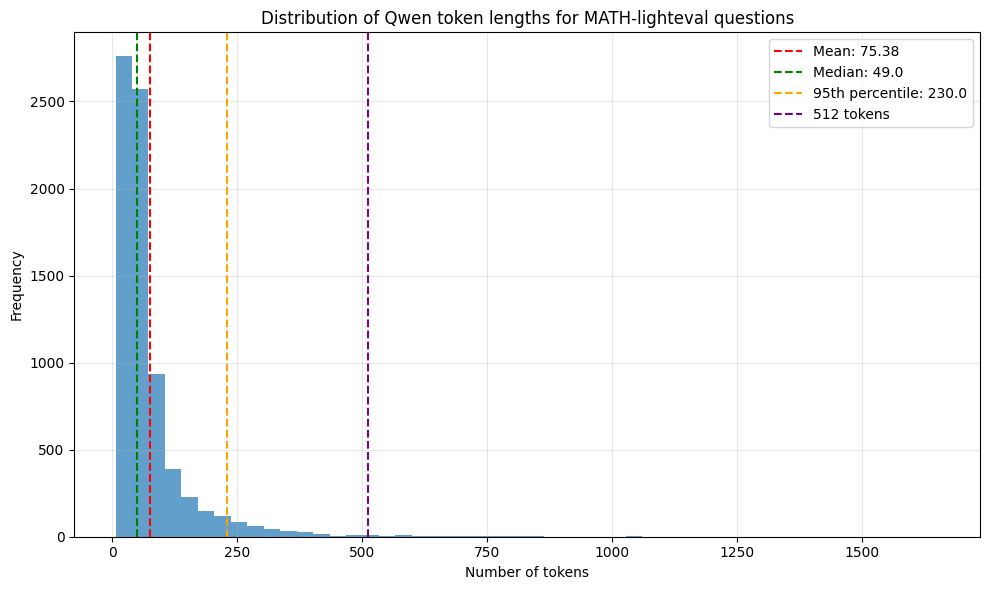

Examples exceeding token limits:
  > 512 tokens: 64 (0.85%)
  > 1024 tokens: 7 (0.09%)
  > 2048 tokens: 0 (0.00%)


In [10]:

# Load the Qwen tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Math-7B")
print(f"Tokenizer loaded: {tokenizer.name_or_path}")

# Function to calculate token lengths
def get_token_lengths(examples, batch_size=100):
    token_lengths = []
    problems = examples['problem']
    
    for i in range(0, len(problems), batch_size):
        batch = problems[i:i+batch_size]
        
        # Tokenize the questions
        encodings = tokenizer(batch, truncation=False, padding=False)
        
        # Get the length of each tokenized question
        batch_lengths = [len(encoding) for encoding in encodings.input_ids]
        token_lengths.extend(batch_lengths)
        
        if i % 1000 == 0:
            print(f"Processed {i}/{len(examples)} examples")
    
    return token_lengths

# Calculate token lengths for the training set
print("Calculating token lengths for training set...")
token_lengths = get_token_lengths(dataset['train'])

# Calculate statistics
avg_length = np.mean(token_lengths)
median_length = np.median(token_lengths)
max_length = np.max(token_lengths)
min_length = np.min(token_lengths)
p90 = np.percentile(token_lengths, 90)
p95 = np.percentile(token_lengths, 95)
p99 = np.percentile(token_lengths, 99)

print(f"Token length statistics:")
print(f"  Average: {avg_length:.2f}")
print(f"  Median: {median_length}")
print(f"  Min: {min_length}")
print(f"  Max: {max_length}")
print(f"  90th percentile: {p90}")
print(f"  95th percentile: {p95}")
print(f"  99th percentile: {p99}")

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50, alpha=0.7)
plt.axvline(x=avg_length, color='r', linestyle='--', label=f'Mean: {avg_length:.2f}')
plt.axvline(x=median_length, color='g', linestyle='--', label=f'Median: {median_length}')
plt.axvline(x=p95, color='orange', linestyle='--', label=f'95th percentile: {p95}')
plt.axvline(x=512, color='purple', linestyle='--', label='512 tokens')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Qwen token lengths for MATH-lighteval questions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check how many examples exceed common context window sizes
exceed_512 = sum(length > 512 for length in token_lengths)
exceed_1024 = sum(length > 1024 for length in token_lengths)
exceed_2048 = sum(length > 2048 for length in token_lengths)

print(f"Examples exceeding token limits:")
print(f"  > 512 tokens: {exceed_512} ({exceed_512/len(token_lengths)*100:.2f}%)")
print(f"  > 1024 tokens: {exceed_1024} ({exceed_1024/len(token_lengths)*100:.2f}%)")
print(f"  > 2048 tokens: {exceed_2048} ({exceed_2048/len(token_lengths)*100:.2f}%)")
